# Credit-card Default Risk
#### by Perry Shyr
___
## _7-of-7. Model Evaluation for Deployment in Production_
![](../image_files/cards.png)

## Problem Statement

### Given a dataset with demographic and borrowing history data for accounts classified as defaulting or not defaulting in October-2005, can I build a supervised model that performs better than identifying only members of the negative non-default class (baseline model) while minimizing the misclassification of either class?  In the context of credit-card lending, if I can predict accounts as belonging to the defaulting class, I want to minimize the number of predicted defaulters who did not actually default that October (lost revenues) while minimizing the number of predicted non-defaulters who did end up defaulting (lost profits).

## Preamble for Model-evaluation Notebook

### In this notebook, I



## A. Code Libraries Used

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
import pickle

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

## B. Import Split/Scaled data and Earlier Models 

In [37]:
from keras.models import load_model
keras_model = load_model('../assets/model_keras.h5')

/Users/perry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
X_train_nf = pd.read_csv('../assets/X_train_split_nf.csv', index_col='ID')
X_test_nf = pd.read_csv('../assets/X_test_split_nf.csv', index_col='ID')

X_train_sc_nf = genfromtxt('../assets/X_train_scaled_nf.csv', delimiter=',')
X_test_sc_nf = genfromtxt('../assets/X_test_scaled_nf.csv', delimiter=',')

X_train_sc = genfromtxt('../assets/X_train_scaled.csv', delimiter=',')
X_test_sc = genfromtxt('../assets/X_test_scaled.csv', delimiter=',')

In [39]:
y_train = pd.read_csv('../assets/y_train_split.csv', index_col=0, header=None)
y_test = pd.read_csv('../assets/y_test_split.csv', index_col=0, header=None)

In [18]:
with open('../pickles/logreg_model.pkl', 'rb') as f:       #  Logistic Regression.
    logreg = pickle.load(f)

In [9]:
with open('../pickles/cart_model.pkl', 'rb') as f:         #  Decision-Tree Classifier.
    model_cart = pickle.load(f)

## C. Model Comparison by Misclassification Metrics

### (i) Neural Networks using Keras front-end

In [41]:
prediction=keras_model.predict(np.array(X_test_sc_nf))
prediction

array([[0.07609029],
       [0.10932643],
       [0.0774623 ],
       ...,
       [0.05350976],
       [0.08976264],
       [0.0775344 ]], dtype=float32)

In [42]:
probas=keras_model.predict_proba(np.array(X_test_sc_nf))
probas

array([[0.07609029],
       [0.10932643],
       [0.0774623 ],
       ...,
       [0.05350976],
       [0.08976264],
       [0.0775344 ]], dtype=float32)

### Let's adjust the classification threshold to 0.35 down from 0.5

In [43]:
X_test_copy = X_test_nf.copy()
X_test_copy['probas_y_hat']=probas
X_test_copy['y'] = y_test
# X_test_copy.loc[:,'pred_thr_35'] = X_test_copy['probas_y_hat'].map(lambda p: 1 if p > .35 else 0)
X_test_copy.loc[:,'pred_thr_50'] = X_test_copy['probas_y_hat'].map(lambda p: 1 if p > .5 else 0)

### Let's plot the effect of this adjustment

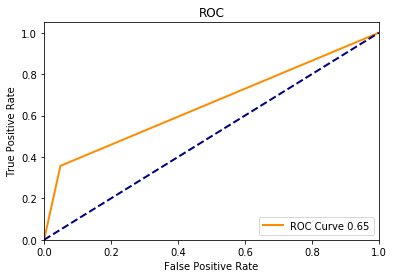

In [13]:
from sklearn.metrics import roc_curve, auc

# Generate False positive rate and True positive rate
fpr, tpr, _ = roc_curve(y_test, X_test_copy['pred_thr_50'])  # Use this if threshold is .5
# fpr, tpr, _ = roc_curve(y_test, X_test_copy['pred_thr_35'])
roc_auc = auc(fpr, tpr)
# fpr

# Plot 
plt.figure()
line_width = 2

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1],[0,1], lw = line_width, linestyle = "--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Let's look at the missclassifications that we are most keenly interested in.

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, X_test_copy['pred_thr_50']).ravel()
print(classification_report(y_test, X_test_copy['pred_thr_50']))
df_cm1 = pd.DataFrame(confusion_matrix(y_test, 
                                       X_test_copy['pred_thr_50']), 
                      columns=["","Actual Oct-Default"])

# tn, fp, fn, tp = confusion_matrix(y_test, X_test_copy['pred_thr_35']).ravel()
# df_cm1 = pd.DataFrame(confusion_matrix(y_test, 
#                                        X_test_copy['pred_thr_35']), 
#                       columns=["","Actual Oct-Default"])

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5834
          1       0.68      0.36      0.47      1658

avg / total       0.80      0.82      0.80      7492



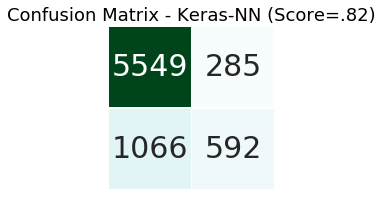

In [15]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - Keras-NN (Score=.82)"
plt.title(title, fontsize=18)
sns.heatmap(df_cm1, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="BuGn", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

### The True-Positive Rate (TPR) for a screen-threshold of 0.35 is...

In [16]:
787 / (787+871)

0.4746682750301568

### ...47.5%.

### The True-Positive Rate (TPR) for a diagnostic-threshold of 0.5 is...¶

In [17]:
592 / (592+1066)

0.35705669481302776

### ...35.7%.

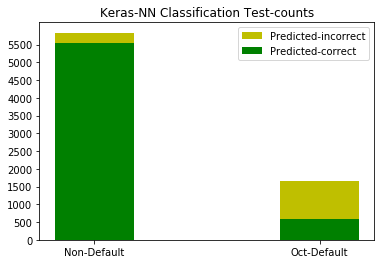

In [18]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pred_right, width, color='g')
p2 = plt.bar(ind, pred_wrong, width, color='y',
             bottom=pred_right)

plt.title('Keras-NN Classification Test-counts')
plt.xticks(ind, ('Non-Default', 'Oct-Default'))
plt.yticks(np.arange(0, 6000, 500))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

### Let's compare the available loss functions.

Text(0, 0.5, 'Observations')

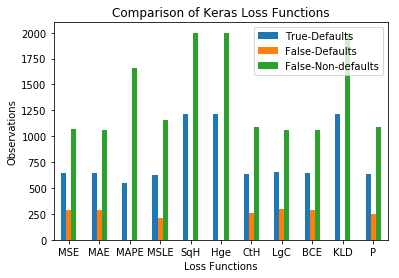

In [12]:
cm = [[1067,591,283],          # Mean-squared Error
              [1057,601,285],  # Mean-absolute Error (lowest False-Non-defaults)
              [1658,0,0],      # Mean-absolute Percentage Error
              [1161,497,208],  # Mean-sqaured Logarithmic Error (lowest False-defaults)
              [0,1658,2000],   # 5,834 > 2,000 (Squared Hinge)
              [0,1658,2000],   # Hinge
              [1087,571,257],  # Categorical-hinge 
              [1064,594,295],  # Log-Cosh
              [1060,598,291],  # Binary Cross-entropy
              [0,1658,2000],   # Kullback-Liebler Divergence
              [1093,565,252]   # Poisson
             ]
loss_funcs = ['MSE', 'MAE',
             'MAPE','MSLE',
             'SqH','Hge',
             'CtH','LgC',
             'BCE','KLD',
             'P']
df = pd.DataFrame(cm, index=loss_funcs).T
pd.concat(
    [df.mean().rename('True-Defaults'), df.min().rename('False-Defaults'), 
     df.max().rename('False-Non-defaults')],
    axis=1).plot.bar(title='Comparison of Keras Loss Functions',rot=0)
plt.xlabel('Loss Functions')
plt.ylabel('Observations')

In [6]:
5834/7492

0.7786972770955686

Text(0, 0.5, 'Metrics')

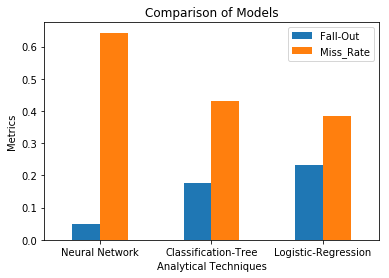

In [65]:
cm = [[0.643,0.049],          # Keras-LogCosh
              [0.430,0.176],  # Class-Tree
              [0.384,0.233]   # LogReg
             ]
loss_funcs = ['Neural Network', 'Classification-Tree',
             'Logistic-Regression']
df = pd.DataFrame(cm, index=loss_funcs).T
pd.concat(
    [df.min().rename('Fall-Out'), 
     df.max().rename('Miss_Rate')],
    axis=1).plot.bar(title='Comparison of Models',rot=0)
plt.xlabel('Analytical Techniques')
plt.ylabel('Metrics')

### (ii) Logistic Regressor Modeling:

In [19]:
predictions_logreg = logreg.predict(X_test_sc_nf)

In [48]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_logreg).ravel()
print(classification_report(y_test, predictions_logreg))

             precision    recall  f1-score   support

          0       0.88      0.77      0.82      5834
          1       0.43      0.62      0.51      1658

avg / total       0.78      0.73      0.75      7492



In [21]:
lr_cm1 = pd.DataFrame(confusion_matrix(y_test, predictions_logreg), 
                      columns=["","True Oct-Default"])

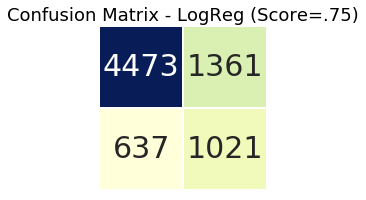

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - LogReg (Score=.75)"
plt.title(title, fontsize=18)
sns.heatmap(lr_cm1, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="YlGnBu", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

### The True-Positive Rate (TPR) is...

In [55]:
1021 / (1021+637)

0.6158021712907117

### ...61.6%.

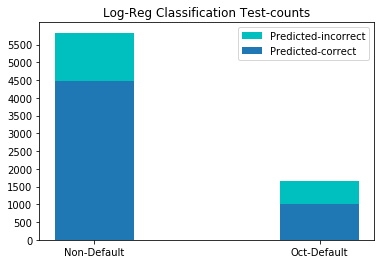

In [33]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    
width = 0.35       

p1 = plt.bar(ind, pred_right, width)
p2 = plt.bar(ind, pred_wrong, width, color='c',
             bottom=pred_right)

plt.title('Log-Reg Classification Test-counts')
plt.xticks(ind, ('Non-Default', 'Oct-Default'))
plt.yticks(np.arange(0, 6000, 500))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

In [22]:
importances = pd.DataFrame(
    {'features': X_train_nf.columns.values.tolist(),
     'coefs': logreg.coef_.tolist()[0]
    })

### Let's list the feature importances in order.

In [23]:
importances = importances.reset_index()

In [24]:
importances = importances.drop('index',axis=1)

In [25]:
importances = importances.set_index('features')

Text(0, 0.5, 'Features')

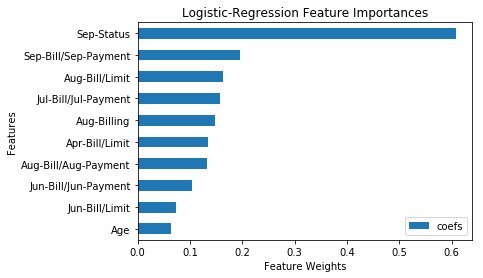

In [58]:
top_10 = importances.sort_values('coefs',ascending=False).head(10)
top_10 = top_10.sort_values('coefs',ascending=True)
bot_10 = importances.sort_values('coefs',ascending=True).head(10)
bot_10 = bot_10.sort_values('coefs',ascending=False)
top_10 = top_10.rename(index={'AGE':'Age', 'leverage_4':'Jun-Bill/Limit', 'bill_to_pay4':'Jun-Bill/Jun-Payment',
                                  'bill_to_pay2':'Aug-Bill/Aug-Payment', 'bill_to_pay1':'Sep-Bill/Sep-Payment',
                                  'bill_to_pay3':'Jul-Bill/Jul-Payment', 'leverage_6':'Apr-Bill/Limit',
                                  'leverage_2':'Aug-Bill/Limit', 'BILL_AMT2':'Aug-Billing',
                                  'PAY_0':'Sep-Status'
                                 })
top_10.plot(kind='barh', title='Logistic-Regression Feature Importances')
plt.xlabel('Feature Weights')
plt.ylabel('Features')

### Activity closer to September plays a predominant role more than earlier activity, suggesting increasing financial strain associated with the expansion of borrowing.

### We see the representation of our interaction terms ('bill_to_pay1) in the importances as a good sign of validation.

Text(0, 0.5, 'Features')

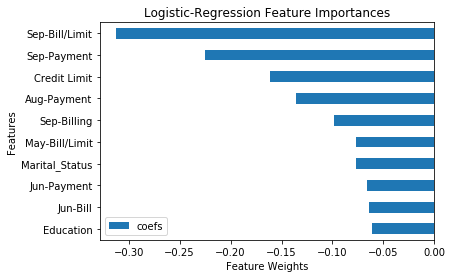

In [32]:
bot_10 = bot_10.rename(index={'EDUCATION':'Education', 'leverage_5':'May-Bill/Limit', 'credit_limit':'Credit Limit',
                                  'PAY_AMT1':'Sep-Payment', 'PAY_AMT4':'Jun-Payment',
                                  'BILL_AMT4':'Jun-Bill', 'PAY_AMT2':'Aug-Payment',
                                  'leverage_1':'Sep-Bill/Limit', 'BILL_AMT1':'Sep-Billing',
                                  'MARRIAGE':'Marital_Status'
                                 })
bot_10
bot_10.plot(kind='barh', title='Logistic-Regression Feature Importances')
plt.xlabel('Feature Weights')
plt.ylabel('Features')

### We can see the important negative importances related to the topping out of leverage and separation of borrowing between the Default and Non-default classes.  It's also noticeable that the leveling off of payments compared with spending might explain the 'PAY_AMT1' and 'PAY_AMT2' importances. 

# Thank you.